In [1]:
import os
import pandas as pd
import numpy as np
import ksvd
import nltk
from nltk import word_tokenize
from tqdm import tqdm
tqdm.pandas()
from stop_words import get_stop_words

english_stop_list = get_stop_words('en')


In [2]:
plain_text_df = pd.read_json('data/level_0_plain_text.json')

In [8]:
plain_text_df['nltk_token'] = plain_text_df['plain_text'].progress_apply(lambda k: [word_tokenize(x.lower()) for x in k])

100%|██████████| 18786/18786 [07:57<00:00, 39.32it/s]


In [3]:
plain_text_df

,opinion_id,flags,plain_text,court_id,date_filed,keep_sw,keep_sw_no
0,458753,True,"[773_F.2d_1004, Ronnie G. ROBINS, Plaintiff-Ap...",ca9,1985-10-03,"[[773_f.2d_1004], [ronnie, g., robins, plainti...","[[773_f.2d_1004], [ronnie, g., robins, plainti..."
1,2621442,True,"[Colorado Court of Appeals, Div. V., *1035 Ken...",coloctapp,2003-01-21,"[[colorado, court, of, appeals, div, v], [1035...","[[colorado, court, appeals, div, v], [1035, ke..."
2,491523,True,"[823 F.2d 1014, 8 Fed. R. Serv. 3d 417, 23 Fed...",ca7,1987-06-10,"[[823, f.2d, 1014], [8, fed, r., serv, 3d, 417...","[[823, f.2d, 1014], [8, fed, r., serv, 3d, 417..."
3,4849283,True,"[Pontisakos & Brandman, PC, Garden City (Eliza...",nyappdiv,2021-01-19,"[[pontisakos, brandman, pc, garden, city, eliz...","[[pontisakos, brandman, pc, garden, city, eliz..."
4,1802247,True,"[United States District Court, N.D. Georgia, A...",gand,1993-07-22,"[[united, states, district, court, n.d, georgi...","[[united, states, district, court, n.d, georgi..."
...,...,...,...,...,...,...,...
19222,2424823,True,"[United States District Court, D. New Jersey.,...",njd,2000-12-21,"[[united, states, district, court, d., new, je...","[[united, states, district, court, d., new, je..."
19223,4613652,True,"[Larry Sheehan, Bronx, for appellant., Darcel ...",nyappdiv,2019-04-25,"[[larry, sheehan, bronx, for, appellant], [dar...","[[larry, sheehan, bronx, appellant], [darcel, ..."
19224,2424827,True,"[United States District Court, D. Connecticut....",ctd,2001-01-02,"[[united, states, district, court, d., connect...","[[united, states, district, court, d., connect..."
19225,3383506,True,[The Honorable Charlie Green Lee County Clerk ...,flaag,2002-01-30,"[[the, honorable, charlie, green, lee, county,...","[[honorable, charlie, green, lee, county, cler..."


In [21]:
import spacy
nlp = spacy.load("en_core_web_sm")

# This removes punct, stopwords (should have a version to keep stopwords)
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, keep_stopwords = False, MAX_LEN=1500000):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # we check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            if keep_stopwords:
                if w.text != '\n' and not w.is_punct and len(w.text.strip()) > 0:
                    normalized.append(str(w.lemma_))
            else:
                if w.text != '\n' and not w.is_stop and not w.is_punct and len(w.text.strip()) > 0:
                # we add the lematized version of the word
                    normalized.append(str(w.lemma_))
    else:
        for w in doc:
            if keep_stopwords:
                if w.text != '\n' and not w.is_punct and len(w.text.strip()) > 0:
                    normalized.append(str(w.lemma_))
            else:
                # if it's not a stop word or punctuation mark, add it to our article
                if w.text != '\n' and not w.is_stop and not w.is_punct and len(w.text.strip()) > 0:
                # we add the lematized version of the word
                    normalized.append(str(w.text.strip()))

    return normalized

In [26]:
plain_text_df['keep_sw'] = plain_text_df['nltk_token'].progress_apply(lambda k: [normalizeTokens(word_list, lemma=False, keep_stopwords=True) for word_list in k])
plain_text_df['keep_sw_no'] = plain_text_df['nltk_token'].progress_apply(lambda k: [normalizeTokens(word_list, lemma=False, keep_stopwords=False) for word_list in k])
plain_text_df.to_json('data/level_0_plain_text.json')

100%|██████████| 18786/18786 [1:44:44<00:00,  2.99it/s]  


In [91]:
# Save space
plain_text_df = plain_text_df.drop(columns = ['nltk_token'])
plain_text_df.to_json('data/level_0_plain_text.json')

In [29]:
paragraph_motion = []
motions_kw = ['motion', 'motions']
for idx, row in plain_text_df.iterrows():
    for word_list in row['keep_sw']:
        if any(value in word_list for value in motions_kw):
            paragraph_motion.append(word_list)

In [41]:
paragraph_motion_monell = []
monell_kw = ['monell']
for idx, row in plain_text_df.iterrows():
    for word_list in row['keep_sw']:
        if any(value in word_list for value in monell_kw):
            paragraph_motion_monell.append(word_list)

In [6]:
keep_sw_corpus = plain_text_df['keep_sw'].progress_apply(lambda doc: [word for para in doc for word in para])
# no_sw_corpus = plain_text_df['keep_sw_no'].progress_apply(lambda doc: [word for para in doc for word in para])

  0%|          | 0/18786 [00:00<?, ?it/s]

100%|██████████| 18786/18786 [00:09<00:00, 1923.66it/s]


In [7]:
# Redo Preprocessing
import gensim
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

bigram_model_with_stop = Phrases(keep_sw_corpus, min_count=500, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrased_with_stop = bigram_model_with_stop[keep_sw_corpus]

# trigram_model_with_stop = Phrases(bigram_sentences, min_count=100, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)
# phrased_with_stop = trigram_model_with_stop[bigram_sentences]

In [8]:
phrased_with_stop = list(phrased_with_stop)
phrased_with_stop_temp = []
for doc in phrased_with_stop:
    new_wl = [word for word in doc if word not in english_stop_list]
    phrased_with_stop_temp.append(new_wl)

In [50]:
bigram_model_no_stop = Phrases(no_sw_corpus, min_count=100, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)
bigram_sentences = bigram_model_no_stop[no_sw_corpus]

trigram_model_no_stop = Phrases(bigram_sentences, min_count=100, threshold=5, connector_words=ENGLISH_CONNECTOR_WORDS)
phrased_no_stop = trigram_model_no_stop[bigram_sentences]

In [58]:
phrased_with_stop = list(phrased_with_stop)
phrased_no_stop = list(phrased_no_stop)

In [59]:
phrased_with_stop_temp = []
for doc in phrased_with_stop:
    new_wl = [word for word in doc if word not in english_stop_list]
    phrased_with_stop_temp.append(new_wl)

In [62]:
len(phrased_with_stop_temp), len(plain_text_df)

(18786, 18786)

In [63]:
# Do Dynamic Word Embedding with Motion, Claim 
CBOW_W2V = gensim.models.word2vec.Word2Vec(phrased_with_stop_temp, window=25, min_count=5, sg=0, workers=8)
skipgram_W2V = gensim.models.word2vec.Word2Vec(phrased_with_stop_temp, window=25, min_count=5, sg=1, workers=8)

In [76]:
skipgram_W2V.wv.most_similar('motion')

[('grant', 0.8446599841117859),
 ('pursuant_to_fed.r.civ.p', 0.7969455122947693),
 ('file_a_motion', 0.7957056760787964),
 ('deny_the_motion', 0.7809934616088867),
 ('motion_to_dismiss', 0.7741988897323608),
 ('pursuant_to_federal_rule', 0.7734485268592834),
 ('deny', 0.772513210773468),
 ('civil_procedure', 0.7697664499282837),
 ('opposition_to_the_motion', 0.7686389684677124),
 ('motion_to_amend', 0.7655220031738281)]

In [45]:
skipgram_W2V.wv.most_similar('violate')

NameError: name 'skipgram_W2V' is not defined

In [95]:
from gensim.models import KeyedVectors

CBOW_W2V.save("data/w2v/CBOW_W2V_full.model")
skipgram_W2V.save('data/w2v/skipgram_W2V_full.model')

## Dynamic Word2Vec

In [9]:
# First, label the data with 
plain_text_df = plain_text_df.drop(columns=['keep_sw_no'])
len(phrased_with_stop_temp), len(plain_text_df)

(18786, 18786)

In [11]:
decade_series = plain_text_df['date_filed'].progress_apply(lambda k: int(k.split('-')[0]) // 10 * 10)
ready_input = pd.DataFrame({'decade':decade_series, 'corpus':phrased_with_stop_temp})
filtered_corpus = ready_input[ready_input['decade'] >= 1960]
# filtered_corpus = filtered_corpus[filtered_corpus['decade'] <= 2010]
filtered_corpus['decade'] = filtered_corpus['decade'].apply(lambda value: 2010 if value == 2020 else value)


100%|██████████| 18786/18786 [00:00<00:00, 778291.14it/s]


In [17]:
import copy

def calc_syn0norm(model):
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)


def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    base_vecs = [in_base_embed.wv.get_vector(w, norm=True) for w in set(in_base_embed.wv.index_to_key)]
    other_vecs = [in_other_embed.wv.get_vector(w, norm=True) for w in set(in_other_embed.wv.index_to_key)]

    ### Check NaN and Infinity ###
    if np.isnan(np.array(other_vecs)).any() or np.isnan(np.array(base_vecs)).any():
        raise ValueError("NaN values found in embedding vectors")
    if np.isinf(np.array(other_vecs)).any() or np.isinf(np.array(base_vecs)).any():
        raise ValueError("Infinite values found in embedding vectors")

    ### Use float64 to calculate SVD ###
    m = np.array(other_vecs, dtype=np.float64).T.dot(np.array(base_vecs, dtype=np.float64))
    u, _, v = np.linalg.svd(m)

    ### Conduct Procrustes ###
    ortho = u.dot(v)
    other_embed.wv.vectors = (np.array(other_vecs, dtype=np.float64)).dot(ortho)

    return other_embed

def intersection_align_gensim(m1,m2, words=None):
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count")  + m2.wv.get_vecattr(w, "count") ,reverse=True)

    for m in [m1,m2]:
        new_arr = [m.wv.get_vector(w,norm=True) for w in common_vocab]

        m.index2word = common_vocab
        # old_vocab = m.wv.index_to_key
        new_vocab = []
        k2i={}
        for new_index,word in enumerate(common_vocab):
            new_vocab.append(word)
            k2i[word]=new_index
        m.wv.index_to_key=new_vocab
        m.wv.key_to_index=k2i
        m.wv.vectors=np.array(new_arr)

    return (m1,m2)

In [18]:
def compareModels(df, category, text_column_name='tokenized_sents_lower', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    print(cats)
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

def rawModels(df, category, text_column_name='tokenized_sents_lower', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        
        #swapped sum()
        #embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum(), window=25, min_count=5, sg=1, workers=8)
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name], window=25, min_count=5, sg=1, workers=8)
    return embeddings_raw

In [24]:
filtered_corpus[filtered_corpus['decade']==2010]

,decade,corpus
3,2010,"[pontisakos, brandman, pc, garden, city, eliza..."
5,2010,"[united_states, district_court, n.d, georgia, ..."
8,2010,"[876_f.2d_477, james, johnson, jr, plaintiff, ..."
9,2010,"[876_f.2d_477, james, johnson, jr, plaintiff, ..."
14,2010,"[i., introduction, plaintiff, bring, product, ..."
...,...,...
19191,2010,"[cross, petition, certification, deny]"
19211,2010,"[question, case, arise, upon, counter, claim, ..."
19220,2010,"[342_f.3d_1100, windel, ray, workman, petition..."
19223,2010,"[larry, sheehan, bronx, appellant, darcel, d.,..."


In [25]:
rawEmbeddings, comparedEmbeddings = compareModels(filtered_corpus, 'decade', 'corpus')

[1960, 1970, 1980, 1990, 2000, 2010]


In [66]:
rawEmbeddings[1990].wv.most_similar('civil_right')

[('dispose', 2.222421206047585e-05),
 ('breach', 2.0281973904866927e-05),
 ('process', 2.0109676530405756e-05),
 ('regard', 1.896851988880006e-05),
 ('francis', 1.7465897114311735e-05),
 ('mile', 1.629284414767299e-05),
 ('step', 1.4583215829374822e-05),
 ('conscience', 1.4376668290100112e-05),
 ('force', 1.4246938342972309e-05),
 ('hammond', 1.3459163968376579e-05)]

In [63]:
comparedEmbeddings[1960][2].wv.most_similar('police')

[('wright', 0.00022364189324787918),
 ('national_bank', 0.00017693159338899302),
 ('proximate_cause', 0.00016151064088607402),
 ('insurance_policy', 7.53066763798585e-05),
 ('yes', 6.857800162997817e-05),
 ('indeterminate', 6.462387487631332e-05),
 ('notation', 5.9089982274860805e-05),
 ('disciplinary_action', 5.5464271862725294e-05),
 ('jensen', 5.3388366733535654e-05),
 ('helena', 5.026983430491756e-05)]

In [29]:
import sklearn

def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

In [30]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))

    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        try:
            dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0].wv[word], axis = 0), np.expand_dims(embed.wv[word], axis = 0))[0,0])
        except:
            pass
    return np.mean(dists)

def findMostDivergent(embeddingsDict):
    original_words = comparedEmbeddings[1960][0].wv.index_to_key
    for embeds in embeddingsDict.values():
        for embed in embeds:
            original_words = set(original_words).intersection(set(embed.wv.index_to_key))
    words = set(original_words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [44]:
comparedEmbeddings[1960][0].wv.index_to_key

['`',
 "'s",
 'defendant',
 'court',
 'v.',
 'state',
 'officer',
 'case',
 'trial',
 'evidence',
 'plaintiff',
 'claim',
 'see',
 'jury',
 'use',
 'police',
 'find',
 'make',
 'also',
 'law',
 'may',
 'fact',
 'arrest',
 'one',
 'act',
 'right',
 'issue',
 'time',
 '1',
 'I',
 'appellant',
 'hold',
 'whether',
 'must',
 'action',
 'testify',
 'u.s',
 'city',
 'force',
 'however',
 'two',
 'order',
 'united_states',
 'person',
 '2',
 'rule',
 'conduct',
 'judge',
 'can',
 'question',
 'charge',
 '2d',
 'require',
 'give',
 'f.2d',
 'testimony',
 'take',
 'appeal',
 'district_court',
 'allege',
 'judgment',
 'present',
 'first',
 'record',
 'will',
 'without',
 'statement',
 'provide',
 'instruction',
 '3',
 'motion',
 'argue',
 'follow',
 'say',
 'supra',
 'sentence',
 'consider',
 'support',
 'victim',
 'deny',
 'counsel',
 'fail',
 'show',
 'decision',
 'federal',
 'crime',
 'upon',
 'conclude',
 'result',
 'mr',
 'section',
 'statute',
 'witness',
 'offense',
 'note',
 'l._ed',
 's'

In [31]:
wordDivergences = findMostDivergent(comparedEmbeddings)
wordDivergences[:20]

Found 7150 words to compare


[('originate', 0.7948492033760775),
 ('behind', 0.7696972552445004),
 ('p2d', 0.7663445261650512),
 ('679', 0.7639149945790117),
 ('collins', 0.7626472913775801),
 ('heir', 0.7619000833331206),
 ('speed', 0.7584195520824307),
 ('normal', 0.7575011840990973),
 ('cattle', 0.7550854627799323),
 ('479', 0.7534029230617296),
 ('app.d.c', 0.752392670677986),
 ('side', 0.748459756129936),
 ('forfeiture', 0.7473454904179669),
 ('529', 0.7441451400713938),
 ('recent', 0.7404204538701697),
 ('697', 0.7402022379683119),
 ('friend', 0.7400148697024043),
 ('ct', 0.7398663466248241),
 ('take_place', 0.7387110749446545),
 ('writer', 0.7370224046586578)]

In [42]:
wordDivergences[-20:]

[('398', 0.5136047998629193),
 ('terry', 0.5130988773026435),
 ('move_party', 0.512011710411664),
 ('homicide', 0.5117798965861172),
 ('closely_relate', 0.5106878681898083),
 ('barricade', 0.509505249030049),
 ('tell', 0.5083539870866258),
 ('hat', 0.5078805837503964),
 ('382', 0.5069562410460181),
 ('946', 0.5060842282981847),
 ('620', 0.5058230668249648),
 ('open', 0.5057540097458094),
 ('deficiency', 0.5052400614938586),
 ('474', 0.5047944784283133),
 ('institution', 0.5022595096339892),
 ('act', 0.5005762897802214),
 ('485', 0.49936863156422),
 ('reviewing', 0.49746402417731966),
 ('hallway', 0.49595885448010857),
 ('reinstate', 0.485258353974732)]

In [69]:
from sklearn.metrics.pairwise import cosine_similarity

focal_words = 'motion' # ['motion', 'claim']
encore_words = ['due_process', 'excessive_force', '1983', 'fourth_amendment', 'fourteenth_amendment', 'fifth_amendment',
                'arrest', 'civil_right']

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)

In [94]:
average_embed_encore = dict()
for word in encore_words:
    arrays = []
    for key in rawEmbeddings.keys():
        arrays.append(rawEmbeddings[key].wv[word])
    average_embed_encore[word] = np.mean(np.array(arrays), axis=0)

In [128]:
targetWord = 'motion'
consine_dist = dict()
for key in rawEmbeddings.keys():
    consine_dist[key] = list()
    for word in encore_words:    
        consine_dist[key].append(cosine_similarity(rawEmbeddings[key].wv[targetWord].reshape(1, -1), rawEmbeddings[key].wv[word].reshape(1, -1))[0][0])

In [129]:
consine_dist


{1960: [0.4369796751771312,
  0.04165751814918804,
  0.753143407730238,
  0.3199728736694802,
  0.25995043589292793,
  0.19918351812879811,
  0.42588448199379086,
  0.10061459969398655,
  0.17802335404930253],
 1970: [0.1937434176099591,
  0.3643206721006924,
  0.25420081956621066,
  0.4100317406394264,
  0.2124014734982754,
  0.25141681156335105,
  0.25220386280098134,
  0.008744949417904048,
  0.33368225428060866],
 1980: [0.1138336217691317,
  0.07020500878270294,
  0.2041954605620741,
  0.19337910840783365,
  0.08658964304672098,
  0.15693325422227392,
  0.18184215444645857,
  0.25125495099455863,
  0.2261872088184287],
 1990: [0.1775493158661513,
  0.14505917535434792,
  0.10652432965246916,
  0.03488544220956945,
  0.28961130955448494,
  0.12060947792016843,
  0.17300996292528045,
  0.18574030667100133,
  0.21041136254733095],
 2000: [0.20969210912288622,
  0.1816046471858325,
  0.24358550131057516,
  0.15154810481714065,
  0.2899977780630123,
  0.4352405320029163,
  0.0635201604

In [152]:
targetWord = 'motion'
motions_label = []
target_vec = []
for key in rawEmbeddings.keys():
    motions_label.append('motion_{}'.format(key))
    target_vec.append(rawEmbeddings[key].wv[targetWord])

In [186]:
tsne = TSNE(n_components=2)

all_vec = list(average_embed_encore.values()) + target_vec
all_vec_red = tsne.fit_transform(all_vec)

encore_dots = all_vec_red[:len(average_embed_encore)]
motion_dots = all_vec_red[len(average_embed_encore):]
len(motion_dots)

c:\Users\aruba\anaconda3\envs\master\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aruba\anaconda3\envs\master\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


6

In [193]:
motion_dots[0], motion_dots[1]

(array([-490.1615 , -109.29826], dtype=float32),
 array([ -56.629074, -165.89882 ], dtype=float32))

C:\Users\aruba\AppData\Local\Temp\ipykernel_18372\2297745984.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([motion_dots[i][0], motion_dots[i+1][0]],


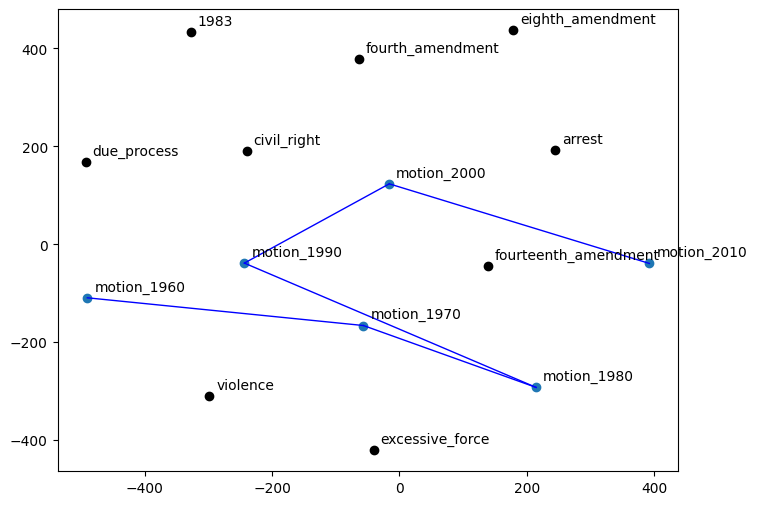

In [200]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(encore_dots[:,0], encore_dots[:,1], color = 'black')

for i, label in enumerate(encore_words):
    ax.annotate(label, (encore_dots[i, 0], encore_dots[i, 1]), xytext=(5, 5), textcoords='offset points')

ax.scatter(motion_dots[:, 0], motion_dots[:, 1])

for i, label in enumerate(motions_label):
    ax.annotate(label, (motion_dots[i, 0], motion_dots[i, 1]), xytext=(5, 5), textcoords='offset points')

# for i in range(len(motion_dots) - 1):
#     plt.arrow(motion_dots[i][0], motion_dots[i][1], motion_dots[i+1][0], motion_dots[i+1][1])   

for i in range(len(motion_dots) - 1):
    ax.plot([motion_dots[i][0], motion_dots[i+1][0]],
            [motion_dots[i][1], motion_dots[i+1][1]],
            'k-', linewidth = 1, color='b') 


In [211]:
targetWord = 'claim'
claim_label = []
target_vec = []
for key in rawEmbeddings.keys():
    claim_label.append('claim_{}'.format(key))
    target_vec.append(rawEmbeddings[key].wv[targetWord])

In [218]:
tsne = TSNE(n_components=2)

all_vec = list(average_embed_encore.values()) + target_vec
all_vec_red = tsne.fit_transform(all_vec)

encore_dots = all_vec_red[:len(average_embed_encore)]
claim_dots = all_vec_red[len(average_embed_encore):]
len(claim_dots)

c:\Users\aruba\anaconda3\envs\master\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\aruba\anaconda3\envs\master\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


6

C:\Users\aruba\AppData\Local\Temp\ipykernel_18372\559667434.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([claim_dots[i][0], claim_dots[i+1][0]],


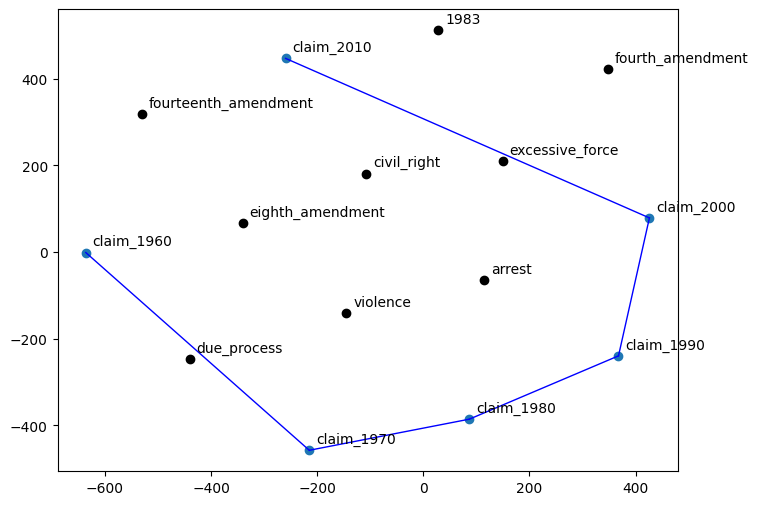

In [219]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(encore_dots[:,0], encore_dots[:,1], color = 'black')

for i, label in enumerate(encore_words):
    ax.annotate(label, (encore_dots[i, 0], encore_dots[i, 1]), xytext=(5, 5), textcoords='offset points')

ax.scatter(claim_dots[:, 0], claim_dots[:, 1])

for i, label in enumerate(claim_label):
    ax.annotate(label, (claim_dots[i, 0], claim_dots[i, 1]), xytext=(5, 5), textcoords='offset points')

# for i in range(len(motion_dots) - 1):
#     plt.arrow(motion_dots[i][0], motion_dots[i][1], motion_dots[i+1][0], motion_dots[i+1][1])   

for i in range(len(motion_dots) - 1):
    ax.plot([claim_dots[i][0], claim_dots[i+1][0]],
            [claim_dots[i][1], claim_dots[i+1][1]],
            'k-', linewidth = 1, color='b') 


In [ ]:
def getDivergenceDF(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            # embed is the w2v models
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0].wv[word], axis = 0),
                                                                             np.expand_dims(embed.wv[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

motion


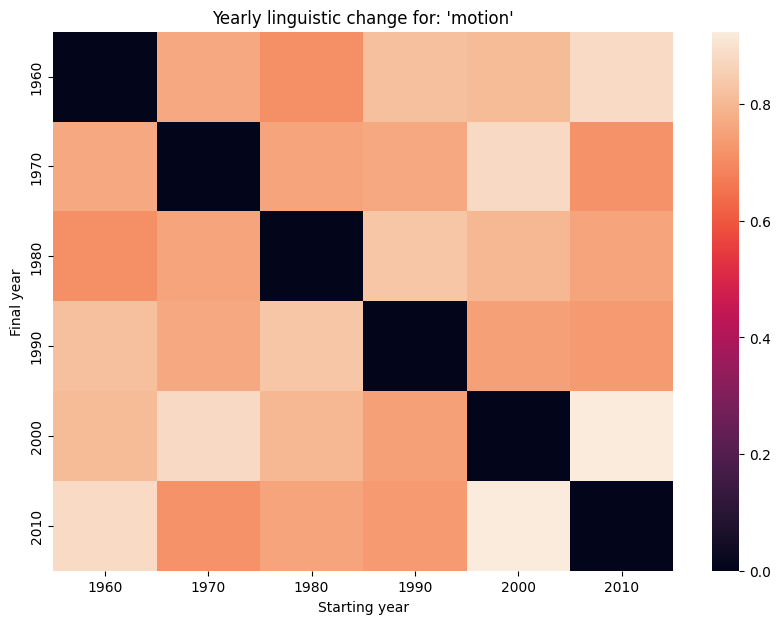

In [39]:
import matplotlib.pyplot as plt
import seaborn

targetWord = 'motion'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()